In [1]:
import torch
from pyqcu.ascend import dslash
from pyqcu.ascend.define import *
# latt_size = (32, 32, 32, 32)
# latt_size = (32, 32, 16, 16)
# latt_size = (16, 16, 16, 32)
# latt_size = (16, 16, 16, 16)
# latt_size = (16, 16, 16, 8)
# latt_size = (16, 16, 8, 8)
# latt_size = (16, 8, 8, 8)
# latt_size = (8, 8, 8, 8)
# latt_size = (8, 16, 16, 32)
latt_size = (16, 16, 16, 32)
# latt_size = (32, 32, 32, 32)
# latt_size = (32, 32, 32, 64)
# latt_size = (4, 8, 8, 8)
# latt_size = (8, 8, 8, 4)
# latt_size = (16, 8, 8, 8)
# latt_size = (8, 8, 8, 16)
# latt_size = (8, 8, 8, 8)
# latt_size = (4, 4, 4, 4)
# latt_size = (2, 2, 2, 2)
# mass = -3.5
# mass = -0.8
# mass = -0.5
# mass = 0.05
# mass = 0.0
mass = -0.05
# kappa = 0.4
# kappa = 0.125
# kappa = 0.5
kappa = 1 / (2 * mass + 8)
dtype = torch.complex128
# dtype = torch.complex64
# dtype = torch.complex32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
print(f"Using device: {device}")
# Initialize lattice gauge theory
wilson = dslash.wilson_mg(
    latt_size=latt_size,
    kappa=kappa,
    dtype=dtype,
    device=device,
    verbose=False
)
clover = dslash.clover(
    latt_size=latt_size,
    kappa=kappa,
    dtype=dtype,
    device=device,
    verbose=False
)
U = wilson.generate_gauge_field(sigma=0.1, seed=42)

wilson.check_su3(U)
clover_term = clover.make_clover(U=U)
# clover_term = torch.zeros_like(clover_term) # just for test, just wilson

b = torch.randn(4, 3, latt_size[3], latt_size[2], latt_size[1], latt_size[0],
                dtype=dtype, device=device)
verbose = True
tol = 1e-9

Using device: cuda


In [2]:
hopping_plus_list = []
hopping_minus_list = []
for ward in range(4):
    hopping_plus_list.append(wilson.give_hopping_plus(ward=ward, U=U))
    hopping_minus_list.append(wilson.give_hopping_minus(ward=ward, U=U))
Ab = wilson.give_wilson(src=b, U=U, with_I=False)
_Ab = torch.zeros_like(b)
for ward in range(4):
    _Ab += wilson.give_wilson_plus(ward=ward, src=b.reshape(
        [12]+list(U.shape[-4:])), hopping=hopping_plus_list[ward]).reshape([4, 3]+list(U.shape[-4:]))
    _Ab += wilson.give_wilson_minus(ward=ward, src=b.reshape(
        [12]+list(U.shape[-4:])), hopping=hopping_minus_list[ward]).reshape([4, 3]+list(U.shape[-4:]))
print(torch.norm(Ab-_Ab).item()/torch.norm(Ab).item())

2.162943493862452e-16


In [3]:
from pyqcu.ascend import inverse
mg = inverse.mg(b=b, wilson=wilson, U=U,
                clover=clover, clover_term=clover_term, tol=tol, verbose=verbose)
mg.init()

self.dof_list:[12, 24, 24, 24, 24]
Building grid list:
  Level 0: 16x16x16x32
  Level 1: 8x8x8x16
  Level 2: 4x4x4x8
  Level 3: 2x2x2x4
self.grid_list:[[32, 16, 16, 16], [16, 8, 8, 8], [8, 4, 4, 4], [4, 2, 2, 2]]
Norm of b:1406.8278680567178
Norm of r:1990.2552756982795
Norm of x0:1254.6238795666827
BICGSTAB-Iteration 0: Residual = 3.431855e+02, Time = 0.102553 s


BICGSTAB-Iteration 1: Residual = 1.133305e+02, Time = 0.102057 s
BICGSTAB-Iteration 2: Residual = 2.320191e+02, Time = 0.102205 s
BICGSTAB-Iteration 3: Residual = 3.800066e+01, Time = 0.102054 s
BICGSTAB-Iteration 4: Residual = 2.937882e+01, Time = 0.102128 s
BICGSTAB-Iteration 5: Residual = 1.659060e+01, Time = 0.102120 s
BICGSTAB-Iteration 6: Residual = 1.050218e+01, Time = 0.102344 s
BICGSTAB-Iteration 7: Residual = 1.613375e+01, Time = 0.102062 s
BICGSTAB-Iteration 8: Residual = 1.295095e+01, Time = 0.102301 s
BICGSTAB-Iteration 9: Residual = 9.225231e+00, Time = 0.102003 s
BICGSTAB-Iteration 10: Residual = 1.023299e+01, Time = 0.102256 s
BICGSTAB-Iteration 11: Residual = 6.655902e+00, Time = 0.101941 s
BICGSTAB-Iteration 12: Residual = 5.000471e+00, Time = 0.102308 s
BICGSTAB-Iteration 13: Residual = 4.622716e+00, Time = 0.101941 s
BICGSTAB-Iteration 14: Residual = 2.680307e+00, Time = 0.102310 s
BICGSTAB-Iteration 15: Residual = 3.322447e+00, Time = 0.102000 s
BICGSTAB-Iteration 

In [4]:
def matvec(src: torch.Tensor, U: torch.Tensor = U, clover_term: torch.Tensor = clover_term) -> torch.Tensor:
    return wilson.give_wilson(src, U)+clover.give_clover(clover_term=clover_term, src=src)


def _matvec(src: torch.Tensor) -> torch.Tensor:
    return mg.op_list[0].matvec(src=src)

In [5]:
%%time
%time Ab = matvec(b)
%time _Ab = _matvec(b)
print(torch.norm(U).item())
print(torch.norm(clover_term).item())
print(torch.norm(Ab).item())
print(torch.norm(_Ab).item())
print(torch.norm(Ab-_Ab).item()/torch.norm(_Ab).item())

CPU times: user 2.39 ms, sys: 252 μs, total: 2.64 ms
Wall time: 2.38 ms
CPU times: user 0 ns, sys: 1.65 ms, total: 1.65 ms
Wall time: 1.59 ms
1254.138748304987
60.382062437247676
1405.5260930152683
1405.5260930152683
1.740426298440458e-16
CPU times: user 1 s, sys: 9.15 ms, total: 1.01 s
Wall time: 1.01 s


In [6]:
%time Ab = matvec(b)
%time _Ab = _matvec(b)

CPU times: user 4.9 ms, sys: 69 μs, total: 4.97 ms
Wall time: 4.18 ms
CPU times: user 1.39 ms, sys: 0 ns, total: 1.39 ms
Wall time: 1.31 ms


In [7]:
b0 = mg.b_list[0]
b1 = inverse.restrict(
    local_ortho_null_vecs=mg.lonv_list[0], fine_vec=b0)
_b0 = inverse.prolong(local_ortho_null_vecs=mg.lonv_list[0], coarse_vec=b1)
_b1 = inverse.restrict(
    local_ortho_null_vecs=mg.lonv_list[0], fine_vec=_b0)
print(_b1.flatten()[:100]/b1.flatten()[:100])

restrict:shape,coarse_dof:(torch.Size([24, 12, 16, 2, 8, 2, 8, 2, 8, 2]), 24)
EeTtZzYyXx,eTtZzYyXx->ETZYX
prolong:shape,fine_dof:(torch.Size([24, 12, 16, 2, 8, 2, 8, 2, 8, 2]), 12)
EeTtZzYyXx,ETZYX->eTtZzYyXx
restrict:shape,coarse_dof:(torch.Size([24, 12, 16, 2, 8, 2, 8, 2, 8, 2]), 24)
EeTtZzYyXx,eTtZzYyXx->ETZYX
tensor([1.0000-1.3944e-18j, 1.0000-1.0102e-16j, 1.0000-4.5430e-16j,
        1.0000+2.2575e-16j, 1.0000-7.1364e-17j, 1.0000+6.2171e-17j,
        1.0000-6.0907e-16j, 1.0000+7.6518e-17j, 1.0000-7.1840e-16j,
        1.0000-5.3085e-17j, 1.0000-2.6222e-16j, 1.0000+8.8965e-17j,
        1.0000+1.4025e-16j, 1.0000-2.8861e-16j, 1.0000-5.6767e-16j,
        1.0000+5.5057e-16j, 1.0000-9.7477e-17j, 1.0000+4.0704e-16j,
        1.0000-7.9599e-17j, 1.0000+1.4131e-16j, 1.0000-2.0159e-16j,
        1.0000-2.0510e-16j, 1.0000+2.3070e-16j, 1.0000+2.4013e-16j,
        1.0000+4.4950e-17j, 1.0000-9.1993e-17j, 1.0000+5.1837e-17j,
        1.0000+1.1329e-17j, 1.0000-1.4683e-16j, 1.0000+9.7722e-17j,
     

In [8]:
# _x = inverse.cg(b=b, matvec=matvec, tol=tol, verbose=verbose)
_x = inverse.bicgstab(b=b, matvec=_matvec, tol=tol, verbose=verbose)
# _x = inverse.bicgstab(b=b, matvec=mg.op_list[0].matvec, tol=tol, verbose=verbose)

Norm of b:1253.1175671168098
Norm of r:1883.69523289451
Norm of x0:1254.514576991282
BICGSTAB-Iteration 0: Residual = 4.072062e+02, Time = 0.940938 s
BICGSTAB-Iteration 1: Residual = 1.760147e+02, Time = 0.943083 s
BICGSTAB-Iteration 2: Residual = 1.771517e+02, Time = 0.941176 s
BICGSTAB-Iteration 3: Residual = 1.162567e+02, Time = 0.941226 s
BICGSTAB-Iteration 4: Residual = 7.316283e+01, Time = 0.939607 s
BICGSTAB-Iteration 5: Residual = 6.383779e+01, Time = 0.940367 s
BICGSTAB-Iteration 6: Residual = 4.366836e+01, Time = 0.942154 s
BICGSTAB-Iteration 7: Residual = 4.217503e+01, Time = 0.943091 s
BICGSTAB-Iteration 8: Residual = 5.525828e+01, Time = 0.939410 s
BICGSTAB-Iteration 9: Residual = 4.882774e+01, Time = 0.940500 s
BICGSTAB-Iteration 10: Residual = 6.455378e+01, Time = 0.940410 s
BICGSTAB-Iteration 11: Residual = 1.976102e+02, Time = 0.940515 s
BICGSTAB-Iteration 12: Residual = 1.624061e+02, Time = 0.942827 s
BICGSTAB-Iteration 13: Residual = 2.646299e+02, Time = 0.942069 s
B

BICGSTAB-Iteration 369: Residual = 2.785606e-09, Time = 0.939970 s
BICGSTAB-Iteration 370: Residual = 2.800480e-09, Time = 0.942851 s
BICGSTAB-Iteration 371: Residual = 2.774053e-09, Time = 0.942166 s
BICGSTAB-Iteration 372: Residual = 2.731305e-09, Time = 0.942081 s
BICGSTAB-Iteration 373: Residual = 2.471756e-09, Time = 0.940609 s
BICGSTAB-Iteration 374: Residual = 2.496121e-09, Time = 0.941160 s
BICGSTAB-Iteration 375: Residual = 2.370058e-09, Time = 0.943328 s
BICGSTAB-Iteration 376: Residual = 2.336333e-09, Time = 0.941602 s
BICGSTAB-Iteration 377: Residual = 2.264512e-09, Time = 0.938951 s
BICGSTAB-Iteration 378: Residual = 2.220674e-09, Time = 0.941230 s
BICGSTAB-Iteration 379: Residual = 2.156231e-09, Time = 0.939175 s
BICGSTAB-Iteration 380: Residual = 2.165663e-09, Time = 0.941375 s
BICGSTAB-Iteration 381: Residual = 2.028235e-09, Time = 0.940563 s
BICGSTAB-Iteration 382: Residual = 1.945858e-09, Time = 0.941141 s
BICGSTAB-Iteration 383: Residual = 1.874854e-09, Time = 0.9413

MG-0:Norm of b:1253.1175671168098
MG-0:Norm of r:1253.1175671168098
MG-0:Norm of x0:0.0
B-MG-0-BICGSTAB-Iteration 0: Residual = 3.223626e+02
restrict:shape,coarse_dof:(torch.Size([24, 12, 16, 2, 8, 2, 8, 2, 8, 2]), 24)
EeTtZzYyXx,eTtZzYyXx->ETZYX
MG-1:Norm of b:187.3756801246921
MG-1:Norm of r:187.3756801246921
MG-1:Norm of x0:0.0
B-MG-1-BICGSTAB-Iteration 0: Residual = 7.184428e+01
restrict:shape,coarse_dof:(torch.Size([24, 24, 8, 2, 4, 2, 4, 2, 4, 2]), 24)
EeTtZzYyXx,eTtZzYyXx->ETZYX
MG-2:Norm of b:41.12063376600468
MG-2:Norm of r:41.12063376600468
MG-2:Norm of x0:0.0
B-MG-2-BICGSTAB-Iteration 0: Residual = 1.894639e+01
F-MG-2-BICGSTAB-Iteration 0: Residual = 1.894639e+01, Time = 0.002143 s
B-MG-2-BICGSTAB-Iteration 1: Residual = 1.027853e+01
F-MG-2-BICGSTAB-Iteration 1: Residual = 1.027853e+01, Time = 0.001911 s
B-MG-2-BICGSTAB-Iteration 2: Residual = 1.148718e+01
F-MG-2-BICGSTAB-Iteration 2: Residual = 1.148718e+01, Time = 0.001940 s
B-MG-2-BICGSTAB-Iteration 3: Residual = 8.732773

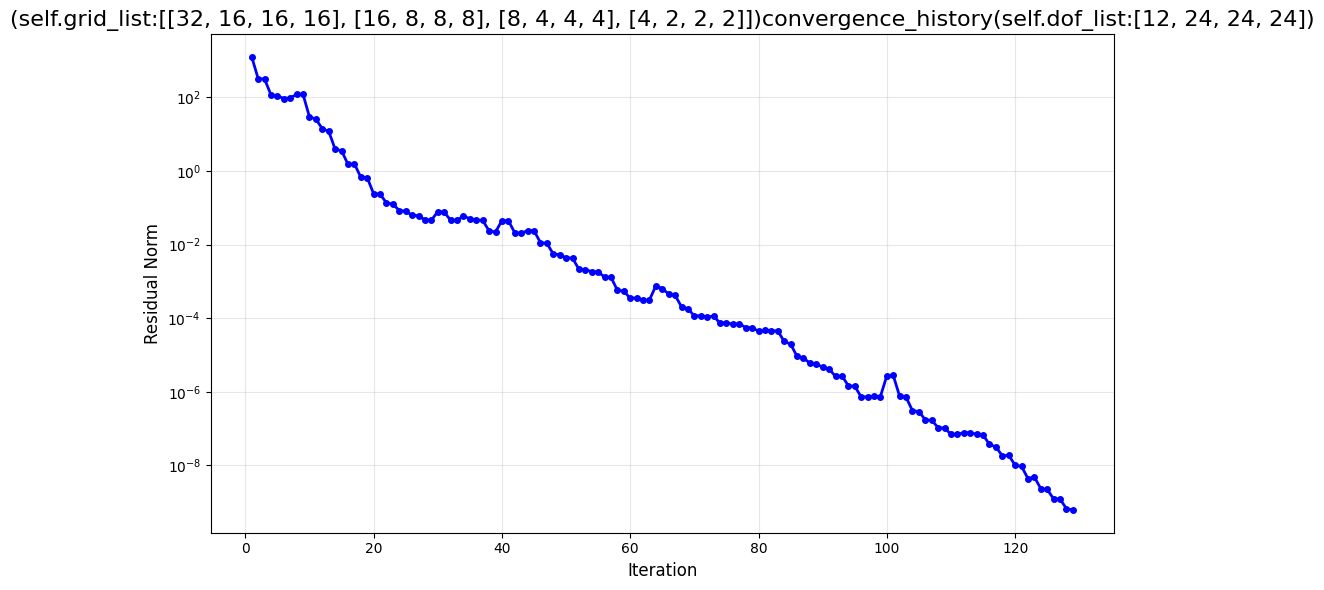

In [9]:
mg.num_levels = 3
x = mg.solve()
mg.plot()

In [10]:
mg.lonv_list[0].shape

torch.Size([24, 12, 16, 2, 8, 2, 8, 2, 8, 2])

In [11]:
(mg.b_list[0]-mg.op_list[0].matvec(x.reshape([12]+list(x.shape[-4:])))).flatten()[:100]

tensor([ 3.7950e-13+1.2079e-13j,  2.0756e-13-5.3069e-14j,
        -1.9673e-13+6.1179e-13j, -6.6891e-15+2.2415e-13j,
        -3.0032e-13+1.7630e-13j,  2.8078e-13+1.2768e-13j,
         2.8688e-13+2.5979e-14j,  8.8707e-14+7.5051e-14j,
        -4.7540e-13+1.4894e-13j,  3.7415e-14+4.3254e-13j,
        -2.5446e-13-2.5446e-13j, -1.7664e-13+9.2482e-14j,
        -2.0095e-14+1.6120e-13j, -1.3223e-13+2.5835e-13j,
        -2.1472e-13-9.5257e-14j,  6.0629e-13+1.5987e-13j,
         3.6371e-13-6.5525e-13j, -6.9394e-13+2.9543e-13j,
        -7.3275e-14-3.2738e-14j, -6.3866e-13-2.9027e-13j,
         2.1083e-13-5.3046e-13j,  9.7998e-14+3.9635e-13j,
         4.4897e-13-1.5765e-13j,  8.2045e-14+3.9146e-13j,
         5.7132e-13+2.7034e-13j, -1.8763e-13-2.4430e-13j,
        -9.8255e-15+1.7575e-13j, -1.4037e-13+1.5082e-13j,
         1.4899e-13+2.0081e-14j,  3.2996e-13+9.4480e-14j,
        -4.4770e-13+5.3624e-14j,  2.9055e-13-1.5313e-13j,
         5.2580e-13-2.5896e-14j,  1.6054e-13-1.4289e-13j,
         1.807

In [12]:
print(torch.norm(x-_x).item()/torch.norm(_x).item())

2.2866744702611053e-11


In [13]:
mg.num_levels

3

In [14]:
index = 0
null_vecs = mg.nv_list[index]
matvec = mg.op_list[index].matvec
for i in range(null_vecs.shape[0]):
    print(
        f"(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]:{(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]}")

(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]:tensor([0.0070+0.0090j, 0.0062+0.0115j, 0.0083+0.0112j, 0.0071+0.0081j,
        0.0085+0.0113j, 0.0109+0.0118j, 0.0100+0.0111j, 0.0111+0.0135j,
        0.0093+0.0124j, 0.0087+0.0137j], device='cuda:0',
       dtype=torch.complex128)
(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]:tensor([ 0.0058+0.0239j,  0.0210+0.0325j,  0.0092+0.0237j, -0.0067+0.0258j,
         0.0015+0.0270j,  0.0104+0.0168j,  0.0241+0.0207j,  0.0062+0.0165j,
         0.0273+0.0159j,  0.0108+0.0282j], device='cuda:0',
       dtype=torch.complex128)
(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]:tensor([0.0077-0.0024j, 0.0091-0.0042j, 0.0085-0.0028j, 0.0085-0.0029j,
        0.0079-0.0022j, 0.0081-0.0022j, 0.0082-0.0030j, 0.0087-0.0032j,
        0.0077-0.0032j, 0.0086-0.0037j], device='cuda:0',
       dtype=torch.complex128)


(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]:tensor([0.0010+0.0169j, 0.0166+0.0115j, 0.0108+0.0125j, 0.0040+0.0098j,
        0.0080+0.0111j, 0.0071+0.0125j, 0.0135+0.0115j, 0.0112+0.0126j,
        0.0131+0.0174j, 0.0162+0.0164j], device='cuda:0',
       dtype=torch.complex128)
(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]:tensor([-1.8053e-03+0.0096j, -1.0051e-02+0.0073j, -8.4865e-03+0.0072j,
        -1.0544e-03+0.0071j, -1.7484e-03+0.0084j,  5.5858e-05+0.0031j,
        -1.5789e-02+0.0022j, -2.5475e-03+0.0162j, -8.1684e-03-0.0041j,
        -8.3037e-03+0.0068j], device='cuda:0', dtype=torch.complex128)
(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]:tensor([0.0039+0.0024j, 0.0040+0.0007j, 0.0033+0.0035j, 0.0037+0.0018j,
        0.0023+0.0018j, 0.0047+0.0026j, 0.0015-0.0006j, 0.0044+0.0019j,
        0.0020-0.0007j, 0.0038+0.0012j], device='cuda:0',
       dtype=torch.complex128)
(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]:tensor([0.0030+0.0036j, 0.0052+0.0045j, 0.0046

In [15]:
mg.nv_list[-1].flatten()[:100]

tensor([0.0291+0.0088j, 0.0293+0.0089j, 0.0295+0.0086j, 0.0301+0.0096j,
        0.0295+0.0090j, 0.0284+0.0083j, 0.0288+0.0086j, 0.0290+0.0087j,
        0.0293+0.0089j, 0.0289+0.0088j, 0.0287+0.0088j, 0.0294+0.0087j,
        0.0294+0.0085j, 0.0299+0.0089j, 0.0297+0.0091j, 0.0294+0.0092j,
        0.0287+0.0089j, 0.0292+0.0093j, 0.0296+0.0093j, 0.0294+0.0094j,
        0.0288+0.0092j, 0.0285+0.0090j, 0.0284+0.0095j, 0.0286+0.0094j,
        0.0286+0.0087j, 0.0287+0.0084j, 0.0294+0.0094j, 0.0292+0.0091j,
        0.0289+0.0094j, 0.0292+0.0089j, 0.0295+0.0088j, 0.0294+0.0091j,
        0.0287+0.0088j, 0.0289+0.0093j, 0.0297+0.0099j, 0.0290+0.0093j,
        0.0286+0.0092j, 0.0284+0.0095j, 0.0285+0.0093j, 0.0292+0.0092j,
        0.0292+0.0095j, 0.0287+0.0092j, 0.0285+0.0086j, 0.0293+0.0090j,
        0.0291+0.0087j, 0.0290+0.0090j, 0.0292+0.0086j, 0.0293+0.0093j,
        0.0291+0.0086j, 0.0302+0.0091j, 0.0295+0.0091j, 0.0297+0.0092j,
        0.0287+0.0089j, 0.0283+0.0088j, 0.0285+0.0086j, 0.0293+0

In [16]:
_null_vec = torch.randn_like(null_vecs[0])
print(torch.norm(matvec(_null_vec)))
print(matvec(_null_vec).flatten()[:20])
_null_vec -= inverse.bicgstab(b=matvec(_null_vec), matvec=matvec, tol=5e-5)
print(torch.norm(_null_vec))
print(_null_vec.flatten()[:20])
_null_vec/=torch.norm(_null_vec).item()
print(
    f"(matvec(_null_vec)/_null_vec).flatten()[:10]:{(matvec(_null_vec)/_null_vec).flatten()[:10]}")

tensor(1407.6408, device='cuda:0', dtype=torch.float64)


tensor([-0.8394+0.3164j,  0.3000+0.1620j, -0.5764+2.0019j, -0.3984+0.2561j,
        -0.8387-0.3017j,  0.0505-1.3869j,  0.4798-0.4081j, -0.1676+0.6234j,
         0.7719+0.4605j, -0.8057+0.3749j, -0.3940+0.4375j,  0.2222-0.8813j,
         0.3794+1.3485j, -1.0155+0.6212j,  0.4769-0.1006j, -0.8676-0.5081j,
        -0.8502-0.5357j,  0.0849+1.1390j, -0.9869-1.8866j,  0.5297+1.5766j],
       device='cuda:0', dtype=torch.complex128)
Norm of b:1407.6407705444258
Norm of r:1989.9717730261966
Norm of x0:1254.2159521514864
BICGSTAB-Iteration 0: Residual = 3.430387e+02, Time = 1.445783 s
BICGSTAB-Iteration 1: Residual = 1.131873e+02, Time = 1.531292 s
BICGSTAB-Iteration 2: Residual = 2.267438e+02, Time = 1.365644 s
BICGSTAB-Iteration 3: Residual = 3.804332e+01, Time = 1.267579 s
BICGSTAB-Iteration 4: Residual = 3.323343e+01, Time = 1.418713 s
BICGSTAB-Iteration 5: Residual = 1.673113e+01, Time = 1.515996 s
BICGSTAB-Iteration 6: Residual = 1.074796e+01, Time = 1.365708 s
BICGSTAB-Iteration 7: Residu

In [17]:
_b = torch.randn_like(null_vecs[0])
_x = inverse.bicgstab(b=_b, matvec=matvec, tol=1e-8)
print((_b-matvec(_x)).flatten()[:100])
print(torch.norm(_b))
print(torch.norm(_x))

Norm of b:1254.4128479757715
Norm of r:1884.6662479717775
Norm of x0:1254.0677071689513
BICGSTAB-Iteration 0: Residual = 4.077258e+02, Time = 1.443937 s
BICGSTAB-Iteration 1: Residual = 1.822271e+02, Time = 1.517144 s
BICGSTAB-Iteration 2: Residual = 1.751877e+02, Time = 1.365637 s
BICGSTAB-Iteration 3: Residual = 1.183993e+02, Time = 1.267111 s
BICGSTAB-Iteration 4: Residual = 7.445918e+01, Time = 1.418662 s
BICGSTAB-Iteration 5: Residual = 5.822256e+01, Time = 1.518768 s
BICGSTAB-Iteration 6: Residual = 3.981741e+01, Time = 1.366989 s
BICGSTAB-Iteration 7: Residual = 1.206069e+02, Time = 1.309580 s
BICGSTAB-Iteration 8: Residual = 2.792777e+02, Time = 1.427706 s
BICGSTAB-Iteration 9: Residual = 6.278380e+01, Time = 1.516515 s
BICGSTAB-Iteration 10: Residual = 4.932042e+01, Time = 1.367131 s
BICGSTAB-Iteration 11: Residual = 2.380472e+01, Time = 1.266758 s
BICGSTAB-Iteration 12: Residual = 2.429747e+01, Time = 1.417259 s
BICGSTAB-Iteration 13: Residual = 2.323365e+01, Time = 1.526076 

KeyboardInterrupt: 

In [ ]:
_null_vec.flatten()[:100]

tensor([0.0019-1.0256e-03j, 0.0021+9.4540e-05j, 0.0024-3.3816e-04j,
        0.0028-3.4458e-04j, 0.0026-4.7556e-04j, 0.0017-3.9379e-04j,
        0.0021-2.5878e-04j, 0.0024-9.4306e-04j, 0.0020-7.5944e-04j,
        0.0023-3.0640e-04j, 0.0024-9.7389e-04j, 0.0020-1.3136e-03j,
        0.0023-8.6710e-04j, 0.0021-3.0868e-04j, 0.0026-9.3663e-04j,
        0.0018-5.8757e-04j, 0.0019-6.7431e-04j, 0.0021-9.8634e-04j,
        0.0019-1.2858e-03j, 0.0020-1.3195e-03j, 0.0022-9.7868e-04j,
        0.0019-5.3213e-04j, 0.0024-9.9275e-04j, 0.0020-1.1991e-03j,
        0.0019-2.8694e-04j, 0.0018-4.4055e-04j, 0.0020-9.7843e-04j,
        0.0023-6.6597e-04j, 0.0019-2.9637e-04j, 0.0026-3.9009e-04j,
        0.0029-6.3376e-04j, 0.0025-1.3437e-03j, 0.0024-4.9012e-04j,
        0.0022-1.1514e-03j, 0.0022-1.3180e-03j, 0.0026-5.3518e-04j,
        0.0022-5.6881e-04j, 0.0023-7.1212e-04j, 0.0025-9.6336e-04j,
        0.0023-1.3604e-03j, 0.0019-3.9339e-04j, 0.0021-5.7357e-04j,
        0.0028-9.9418e-04j, 0.0027-1.2298e-03j, 